**1**. **Dataset Downloading and Loading:**



In [4]:
#Unzipping the file
import zipfile
with zipfile.ZipFile('/content/ml-25m.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [5]:
#Loading the Data:

import pandas as pd
movies = pd.read_csv('/content/ml-25m/movies.csv')

# Exploring the data
print("\nMovie Data:")
print(movies.head())



Movie Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


**2. Data Cleaning and Feature Engineering:**

In [6]:
#Cleaning movie titles with regex
import re

def clean_title(title):
  return re.sub("[^a-zA-Z0-9 ]", "", title) # Return the cleaned title

movies["clean_title"] = movies["title"].apply(clean_title)
movies.head()

,movieId,title,genres,clean_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji 1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men 1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale 1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II 1995


**3. Creating a TD-IDF matrix**

In [7]:
#Creating a TD-IDF matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer with customized stop words removal
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(movies['clean_title'])

**4. Building The Search Function**

In [8]:
#Creating a Search Function
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def search(title):
  title = clean_title(title)
  query_vec = vectorizer.transform([title])
  similarity = cosine_similarity(query_vec, tfidf_matrix).flatten()
  indices = np.argpartition(similarity, -5)[-5:]
  results = movies.iloc[indices][::-1]
  return results

**5. Interactive Search Box Creation**

In [9]:
#Building an interactive search box
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')

display(movie_input, movie_list)

Text(value='Toy Story', description='Movie Title:')

Output()

**6. Collaborative Filtering and Recommendations**

In [10]:
#Reading the movie rating data
ratings = pd.read_csv('/content/ml-25m/ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [11]:
ratings.dtypes

,0
userId,int64
movieId,int64
rating,float64
timestamp,int64


**7. Users who liked the same movie**

In [12]:
#Finding users who liked the same movie
movie_id = 1
similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()
similar_users

array([    36,     75,     86, ..., 162527, 162530, 162533])

**8. Similar user recommendations**

In [13]:
#Similar user recommendations
similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]
similar_user_recs

,movieId
5101,1
5105,34
5111,110
5114,150
5127,260
...,...
24998854,60069
24998861,67997
24998876,78499
24998884,81591


**9. Movies liked by similar users**

In [14]:
#Movies greater than (10 >=) users similar to us liked
similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
similar_user_recs = similar_user_recs[similar_user_recs > .10]
print(similar_user_recs)

movieId
1        1.000000
318      0.445607
260      0.403770
356      0.370215
296      0.367295
           ...   
953      0.103053
551      0.101195
1222     0.100876
745      0.100345
48780    0.100186
Name: count, Length: 113, dtype: float64


**10. Movies liked by all users**

In [15]:
#Finding how much all users like movies
all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
print(all_users)

          userId  movieId  rating   timestamp
0              1      296     5.0  1147880044
29             1     4973     4.5  1147869080
48             1     7361     5.0  1147880055
72             2      110     5.0  1141416589
76             2      260     5.0  1141417172
...          ...      ...     ...         ...
25000062  162541     5618     4.5  1240953299
25000065  162541     5952     5.0  1240952617
25000078  162541     7153     5.0  1240952613
25000081  162541     7361     4.5  1240953484
25000090  162541    50872     4.5  1240953372

[1727573 rows x 4 columns]


**11. Percentage of Users That Recommend These Movies**

In [16]:
#Percentage of user that recommend these movies
all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
print(all_user_recs)

movieId
318      0.342220
296      0.284674
2571     0.244033
356      0.235266
593      0.225909
           ...   
551      0.040918
50872    0.039111
745      0.037031
78499    0.035131
2355     0.025091
Name: count, Length: 113, dtype: float64


**12. Creating a Recommendation Score:**

In [17]:
#Creating a recommendation score
rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ["similar", "all"]
print(rec_percentages)

          similar       all
movieId                    
1        1.000000  0.124728
318      0.445607  0.342220
260      0.403770  0.222207
356      0.370215  0.235266
296      0.367295  0.284674
...           ...       ...
953      0.103053  0.045792
551      0.101195  0.040918
1222     0.100876  0.066877
745      0.100345  0.037031
48780    0.100186  0.068314

[113 rows x 2 columns]


**13. Scores of similar movies liked**

In [18]:
#The score of similar movies liked
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
rec_percentages = rec_percentages.sort_values("score", ascending=False)
print(rec_percentages)

          similar       all     score
movieId                              
1        1.000000  0.124728  8.017414
3114     0.280648  0.053706  5.225654
2355     0.110539  0.025091  4.405452
78499    0.152960  0.035131  4.354038
4886     0.235147  0.070811  3.320783
...           ...       ...       ...
2858     0.216724  0.167634  1.292845
296      0.367295  0.284674  1.290232
79132    0.166817  0.131384  1.269693
4973     0.142501  0.112405  1.267747
2959     0.262649  0.216717  1.211946

[113 rows x 3 columns]


**14. Merging top 10 recommendations with movies data**

In [19]:
#Taking the top 10 recommendations and merging with movies data
rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")

,similar,all,score,movieId,title,genres,clean_title
0,1.000000,0.124728,8.017414,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
3021,0.280648,0.053706,5.225654,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 2 1999
2264,0.110539,0.025091,4.405452,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,Bugs Life A 1998
14813,0.152960,0.035131,4.354038,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,Toy Story 3 2010
4780,0.235147,0.070811,3.320783,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,Monsters Inc 2001
580,0.216618,0.067513,3.208539,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,Aladdin 1992
6258,0.228139,0.072268,3.156862,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,Finding Nemo 2003
587,0.179400,0.059977,2.991150,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,Beauty and the Beast 1991
8246,0.203504,0.068453,2.972889,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,Incredibles The 2004
359,0.253411,0.085764,2.954762,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,Lion King The 1994


**15. Building the recommendation function**

In [20]:
#Builidng a recommendation function
def find_similar_movies(movie_id):
    #Recommendations from users similar to us
    similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()
    similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]

    #Over 10% users who recommended the movie
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
    similar_user_recs = similar_user_recs[similar_user_recs > .10]

    #Common recommendations
    all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
    all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())

    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis = 1)
    rec_percentages.columns = ["similar", "all"]

    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)

    return rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")[["score", "title", "genres"]]

**16. Creating the interactive recommendation widget**

In [21]:
#Creating an interactive recommendation widget
#Input Widget
movie_name_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)

#Output Widget
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]["movieId"]
            display(find_similar_movies(movie_id))

movie_name_input.observe(on_type, names='value')

display(movie_name_input, recommendation_list)

Text(value='Toy Story', description='Movie Title:')

Output()

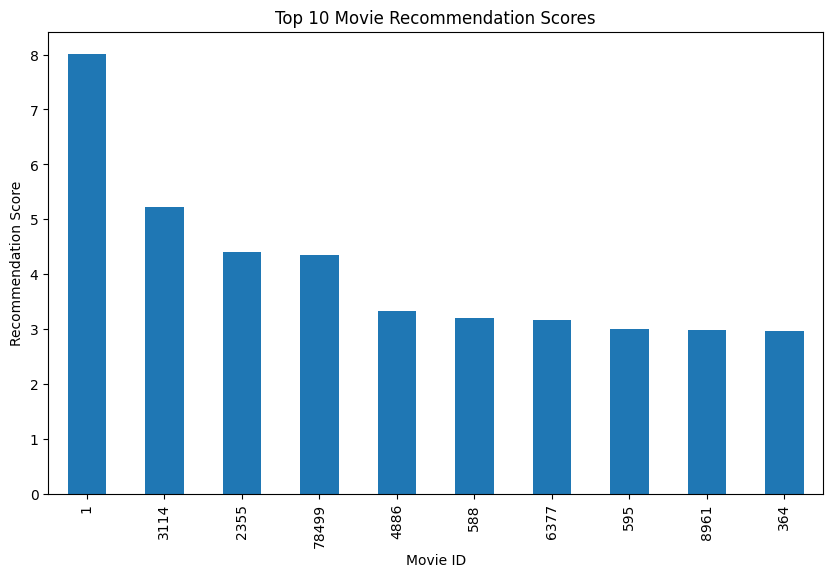

In [22]:
import matplotlib.pyplot as plt

# Plotting the top 10 recommendation scores
rec_percentages["score"].head(10).plot(kind='bar', figsize=(10, 6), title='Top 10 Movie Recommendation Scores')
plt.xlabel('Movie ID')
plt.ylabel('Recommendation Score')
plt.show()
